Analitica eurobet Big Match

preleviamo dati da goldbet big match

predizione

Dati per prevsione.

Dati da prevedere.

In [6]:
import requests
import pandas as pd
from datetime import datetime
import time
import json
from pathlib import Path

class VirtualOddsCollector:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36',
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate, br, zstd',
            'Accept-Language': 'en-US,en;q=0.6',
            'Origin': 'https://www.eurobet.it',
            'X-EB-Accept-Language': 'it_IT',
            'X-EB-MarketId': '5',
            'X-EB-PlatformId': '1',
            'Connection': 'keep-alive',
            'Referer': 'https://www.eurobet.it/'
        }
        self.data_dir = Path('data')
        self.data_dir.mkdir(exist_ok=True)
        self.csv_filename = self.data_dir / 'virtual_odds_detail.csv'
        self.base_url = "https://virtualservice.eurobet.it/virtual-detail-service/virtual-schedule/services/22/sport/{}"

        print(f"File will be saved to: {self.csv_filename}")

    def get_match_odds(self, match_code):
        """Get odds for a specific match"""
        url = self.base_url.format(match_code)
        try:
            print(f"Fetching data for match code: {match_code}")
            response = requests.get(url, headers=self.headers, timeout=10)
            response.raise_for_status()

            data = response.json()
            if 'result' not in data or 'eventdetail' not in data['result']:
                print(f"No valid data found for match {match_code}")
                return None

            event_info = data['result']['eventdetail']['eventInfo']
            bet_groups = data['result']['eventdetail']['betGroupList']

            match_data = {
                'match_code': match_code,
                'timestamp': datetime.fromtimestamp(event_info['eventData']/1000).strftime('%Y-%m-%d %H:%M:%S'),
                'home_team': event_info['teamHomeDescription'],
                'away_team': event_info['teamAwayDescription'],
                'channel': event_info['channelDescription'],
                'event_code': event_info['eventCode'],
                'program_code': event_info['programCode'],
                'collection_time': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }

            for bet_group in bet_groups:
                bet_type = bet_group['betDescription']
                market_id = bet_group['marketId']

                if bet_group['oddGroupList'] and bet_group['oddGroupList'][0]['oddList']:
                    odds = bet_group['oddGroupList'][0]['oddList']

                    for odd in odds:
                        desc = odd['oddDescription']
                        value = odd['oddValue']
                        result_code = odd['resultCode']

                        key_base = f"{bet_type}_{desc}".lower().replace('/', '_').replace(' ', '_')
                        match_data[f"{key_base}_odds"] = value
                        match_data[f"{key_base}_code"] = result_code

            print(f"Successfully collected odds for {match_data['home_team']} vs {match_data['away_team']}")
            return match_data

        except requests.exceptions.RequestException as e:
            print(f"Network error for match {match_code}: {e}")
        except json.JSONDecodeError as e:
            print(f"JSON parsing error for match {match_code}: {e}")
        except Exception as e:
            print(f"Unexpected error for match {match_code}: {e}")
        return None

    def collect_matches(self, match_codes):
        """Collect odds for multiple matches"""
        all_matches = []

        print(f"\nStarting collection for match codes: {match_codes}")

        for match_code in match_codes:
            match_data = self.get_match_odds(match_code)
            if match_data:
                all_matches.append(match_data)
            time.sleep(1)

        if not all_matches:
            print("No match data collected!")
            return pd.DataFrame()

        df = pd.DataFrame(all_matches)

        if self.csv_filename.exists():
            try:
                existing_df = pd.read_csv(self.csv_filename)
                print(f"Loaded {len(existing_df)} existing records")
                df = pd.concat([existing_df, df], ignore_index=True)
                df = df.drop_duplicates(subset=['match_code', 'timestamp'], keep='last')
                print(f"After merging and removing duplicates: {len(df)} records")
            except Exception as e:
                print(f"Error loading existing data: {e}")

        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp', ascending=False)

        try:
            df.to_csv(self.csv_filename, index=False)
            print(f"\nSuccessfully saved data to {self.csv_filename}")
            print(f"Total matches in database: {len(df)}")

            print("\nPreview of saved data:")
            basic_cols = ['timestamp', 'home_team', 'away_team']
            odds_cols = [col for col in df.columns if '1x2_finale' in col and 'odds' in col]
            print(df[basic_cols + odds_cols].head())

        except Exception as e:
            print(f"Error saving data: {e}")

        return df

# Variabili per generare i codici delle partite
BASE_CODE = "55_2402405106"  # Codice base
START_NUMBER = 160 # Numero iniziale

if __name__ == "__main__":
    # Genera 5 codici incrementando di 2 ogni volta
    match_codes = []
    current_number = START_NUMBER

    for _ in range(5):
        match_code = f"{BASE_CODE}_{current_number}"
        match_codes.append(match_code)
        current_number += 2

    collector = VirtualOddsCollector()
    collector.collect_matches(match_codes)

File will be saved to: data\virtual_odds_detail.csv

Starting collection for match codes: ['55_2402405106_160', '55_2402405106_162', '55_2402405106_164', '55_2402405106_166', '55_2402405106_168']
Fetching data for match code: 55_2402405106_160
Network error for match 55_2402405106_160: Expecting value: line 1 column 1 (char 0)
Fetching data for match code: 55_2402405106_162
Network error for match 55_2402405106_162: Expecting value: line 1 column 1 (char 0)
Fetching data for match code: 55_2402405106_164
Network error for match 55_2402405106_164: Expecting value: line 1 column 1 (char 0)
Fetching data for match code: 55_2402405106_166
Network error for match 55_2402405106_166: Expecting value: line 1 column 1 (char 0)
Fetching data for match code: 55_2402405106_168
Network error for match 55_2402405106_168: Expecting value: line 1 column 1 (char 0)
No match data collected!


corezioni dati


In [219]:
import pandas as pd
from datetime import datetime


def prepare_and_save_data():
    try:
        # Leggi virtual_odds_detail.csv
        print("Caricamento dati...")
        virtual_odds = pd.read_csv('data/virtual_odds_detail.csv')

        # Converti timestamp in datetime
        virtual_odds['datetime'] = pd.to_datetime(virtual_odds['timestamp'])

        # Prepara il DataFrame nel formato richiesto
        processed_data = pd.DataFrame({
            'date': virtual_odds['datetime'].dt.strftime('%d-%m-%Y'),
            'hour': virtual_odds['datetime'].dt.strftime('%H:%M:%S'),
            'home_team': virtual_odds['home_team'],
            'away_team': virtual_odds['away_team'],
            'score': '',  # colonna vuota per score futuro
            'home_goals': '',  # colonna vuota per goal futuri
            'away_goals': '',  # colonna vuota per goal futuri
            'datetime': virtual_odds['datetime'],
            'odds_1': virtual_odds['1x2_finale_1_odds'].astype(float),
            'result': '',  # colonna vuota per risultato futuro
            'over_under_25': '',  # colonna vuota per over/under futuro
            'odds_over_under_25': virtual_odds['under_over_2.5_over_odds'].astype(float),
            'goal_no_goal': '',  # colonna vuota per goal/no goal futuro
            'odds_goal_no_goal': virtual_odds['goal_no_goal_goal_odds'].astype(float)
        })

        # Ordina per datetime
        processed_data = processed_data.sort_values('datetime')

        # Salva in CSV
        processed_data.to_csv('previsione.csv', index=False)

        print(f"\nProcessate e salvate {len(processed_data)} partite in previsione.csv")
        print("\nAnteprima dei dati salvati:")
        print(processed_data[['date', 'hour', 'home_team', 'away_team', 'odds_1', 'odds_over_under_25',
                              'odds_goal_no_goal']].head())

    except Exception as e:
        print(f"Errore durante l'elaborazione: {str(e)}")
        raise


if __name__ == "__main__":
    prepare_and_save_data()

Caricamento dati...

Processate e salvate 10 partite in previsione.csv

Anteprima dei dati salvati:
         date      hour home_team away_team  odds_1  odds_over_under_25  \
9  22-11-2024  12:25:00       LAZ       NAP   185.0               184.0   
8  22-11-2024  12:30:00       ROM       FIO   201.0               187.0   
7  22-11-2024  12:35:00       MIL       INT   277.0               184.0   
6  22-11-2024  12:40:00       JUV       LAZ   235.0               190.0   
5  22-11-2024  12:45:00       ROM       NAP   221.0               189.0   

   odds_goal_no_goal  
9              203.0  
8              200.0  
7              198.0  
6              194.0  
5              196.0  


prevsione

In [220]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model
import os
import logging
from datetime import datetime

class BettingLogger:
    """Classe per gestire il logging dell'applicazione"""
    @staticmethod
    def setup():
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler('betting_predictions.log'),
                logging.StreamHandler()
            ]
        )

class OddsCalculator:
    """Classe per i calcoli relativi alle quote e probabilità"""
    @staticmethod
    def convert_odds_to_probability(odds):
        """Converte le quote dal formato moltiplicatore a probabilità"""
        return (1 / odds) * 100

    @staticmethod
    def calculate_kelly_criterion(probability, odds, f=0.5):
        """Calcola la percentuale ottimale di bankroll da scommettere"""
        p = probability
        q = 1 - p
        b = odds - 1
        kelly = (b * p - q) / b
        return max(0, kelly * f)

    @staticmethod
    def get_betting_recommendation(probability, bookmaker_odds, threshold=0.05):
        """Genera raccomandazioni per le scommesse"""
        bookmaker_prob = OddsCalculator.convert_odds_to_probability(bookmaker_odds) / 100
        edge = probability - bookmaker_prob
        kelly = OddsCalculator.calculate_kelly_criterion(probability, bookmaker_odds)
        ev = (probability * (bookmaker_odds - 1) - (1 - probability)) * 100

        recommendation = {
            'edge_percentage': edge * 100,
            'kelly_percentage': kelly * 100,
            'expected_value': ev
        }

        if edge > threshold:
            recommendation.update({
                'decision': 'SCOMMETTI',
                'confidence': 'ALTA' if edge > 0.1 else 'MEDIA',
                'suggested_stake': f"{kelly * 100:.1f}% del bankroll"
            })
        elif edge < -threshold:
            recommendation.update({
                'decision': 'NON SCOMMETTERE',
                'confidence': 'ALTA',
                'reason': 'Valore negativo'
            })
        else:
            recommendation.update({
                'decision': 'NEUTRALE',
                'confidence': 'BASSA',
                'reason': 'Valore insufficiente'
            })

        return recommendation

class DrawPredictor:
    """Classe principale per la predizione dei pareggi"""
    def __init__(self, model_path='lstm_model.keras'):
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Modello non trovato: {model_path}")

        try:
            self.team_encoder = LabelEncoder()
            self.scaler = StandardScaler()
            self.model = load_model(model_path)
            self.sequence_length = 3
            logging.info("Modello caricato con successo")
        except Exception as e:
            logging.error(f"Errore nel caricamento del modello: {str(e)}")
            raise

    def prepare_features(self, df):
        """Prepara le feature per il modello"""
        try:
            features = df.copy()

            # Verifica e pulizia dati
            for col in ['home_team', 'away_team']:
                features[col] = features[col].str.strip().str.upper()

            # Verifica colonne necessarie
            required_columns = ['home_team', 'away_team', 'odds_1', 'odds_over_under_25', 'odds_goal_no_goal']
            missing_columns = [col for col in required_columns if col not in features.columns]
            if missing_columns:
                raise ValueError(f"Colonne mancanti: {missing_columns}")

            # Encoding delle squadre
            all_teams = pd.concat([features['home_team'], features['away_team']]).unique()
            if len(all_teams) < 2:
                raise ValueError("Necessarie almeno due squadre diverse")

            self.team_encoder.fit(all_teams)
            features['home_team_enc'] = self.team_encoder.transform(features['home_team'])
            features['away_team_enc'] = self.team_encoder.transform(features['away_team'])

            # Preparazione feature numeriche
            feature_cols = ['home_team_enc', 'away_team_enc', 'odds_1', 'odds_over_under_25', 'odds_goal_no_goal']

            # Gestione quote e conversione
            for col in feature_cols[2:]:
                features[col] = pd.to_numeric(features[col], errors='coerce')
                if features[col].isnull().any():
                    mean_value = features[col].mean()
                    logging.warning(f"Valori nulli in {col}, sostituiti con la media: {mean_value:.2f}")
                    features[col] = features[col].fillna(mean_value)
                features[f'{col}_prob'] = OddsCalculator.convert_odds_to_probability(features[col]) / 100

            X = features[feature_cols]
            X_scaled = self.scaler.fit_transform(X)

            if np.isnan(X_scaled).any():
                raise ValueError("Trovati valori NaN dopo la standardizzazione")

            X_reshaped = np.array([np.repeat([x], self.sequence_length, axis=0) for x in X_scaled])
            return X_reshaped

        except Exception as e:
            logging.error(f"Errore nella preparazione delle features: {str(e)}")
            raise

    def predict_draws(self, df):
        """Effettua le predizioni dei pareggi"""
        try:
            if df.empty:
                raise ValueError("DataFrame vuoto")

            X = self.prepare_features(df)
            draw_probabilities = self.model.predict(X, verbose=0)
            probs = np.clip(draw_probabilities.flatten(), 0, 1)

            logging.info("\nProbabilità previste per ogni partita:")
            for team1, team2, prob in zip(df['home_team'], df['away_team'], probs):
                logging.info(f"{team1} vs {team2}: {prob:.3f}")

            return probs

        except Exception as e:
            logging.error(f"Errore nella predizione: {str(e)}")
            raise

class PredictionAnalyzer:
    """Classe per l'analisi delle predizioni"""
    @staticmethod
    def analyze_predictions(predictions_df):
        try:
            df = predictions_df.copy()

            # Verifica colonne necessarie
            required_cols = ['draw_probability', 'odds_1']
            for col in required_cols:
                if col not in df.columns:
                    raise ValueError(f"Colonna '{col}' mancante")

            # Calcoli base
            df['draw_probability'] = df['draw_probability'].clip(0, 1)
            df['prediction_confidence'] = abs(df['draw_probability'] - 0.5) * 2
            df['bookmaker_probability'] = df['odds_1'].apply(
                lambda x: OddsCalculator.convert_odds_to_probability(x) / 100
            )

            # Calcoli scommesse
            df['edge'] = df['draw_probability'] - df['bookmaker_probability']
            df['kelly_stake'] = df.apply(
                lambda x: OddsCalculator.calculate_kelly_criterion(x['draw_probability'], x['odds_1']),
                axis=1
            )
            df['expected_value'] = (
                df['draw_probability'] * (df['odds_1'] - 1) -
                (1 - df['draw_probability'])
            ) * 100

            # Decisioni scommesse
            df['betting_decision'] = df['edge'].apply(
                lambda x: 'SCOMMETTI' if x > 0.05 else 'NON SCOMMETTERE' if x < -0.05 else 'NEUTRALE'
            )

            # Classificazione probabilità
            PredictionAnalyzer._add_likelihood_classification(df)

            return df

        except Exception as e:
            logging.error(f"Errore nell'analisi delle previsioni: {str(e)}")
            raise

    @staticmethod
    def _add_likelihood_classification(df):
        """Aggiunge la classificazione della probabilità"""
        if len(df) >= 3:
            unique_probs = df['draw_probability'].nunique()
            if unique_probs >= 3:
                try:
                    df['draw_likelihood'] = pd.qcut(
                        df['draw_probability'],
                        q=3,
                        labels=['BASSA', 'MEDIA', 'ALTA'],
                        duplicates='drop'
                    )
                except ValueError:
                    df['draw_likelihood'] = pd.cut(
                        df['draw_probability'],
                        bins=[0, 0.33, 0.66, 1],
                        labels=['BASSA', 'MEDIA', 'ALTA'],
                        include_lowest=True
                    )
            else:
                df['draw_likelihood'] = 'MEDIA'
        else:
            df['draw_likelihood'] = 'MEDIA'

class PredictionSaver:
    """Classe per il salvataggio delle predizioni"""
    @staticmethod
    def save_predictions(df):
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"betting_predictions.csv"

            output_df = df.copy()

            # Arrotondamenti
            columns_to_round = {
                'draw_probability': 3,
                'bookmaker_probability': 3,
                'edge': 3,
                'kelly_stake': 3,
                'expected_value': 2,
                'prediction_confidence': 3
            }

            for col, decimals in columns_to_round.items():
                if col in output_df.columns:
                    output_df[col] = output_df[col].round(decimals)

            # Aggiunta suggerimento scommessa
            output_df['suggested_bet'] = np.where(
                output_df['betting_decision'] == 'SCOMMETTI',
                output_df['kelly_stake'].apply(lambda x: f"Sì ({x*100:.1f}% bankroll)"),
                'No'
            )

            # Ordine colonne per il CSV
            columns_order = [
                'date', 'hour', 'home_team', 'away_team',
                'odds_1', 'draw_probability', 'bookmaker_probability',
                'edge', 'expected_value', 'betting_decision',
                'suggested_bet', 'kelly_stake', 'prediction_confidence',
                'draw_likelihood'
            ]

            # Salvataggio
            save_columns = [col for col in columns_order if col in output_df.columns]
            output_df[save_columns].to_csv(filename, index=False)

            logging.info(f"Previsioni salvate in {filename}")
            return filename

        except Exception as e:
            logging.error(f"Errore nel salvataggio del file: {str(e)}")
            raise

def main():
    """Funzione principale del programma"""
    try:
        BettingLogger.setup()
        logging.info("Inizio elaborazione")

        if not os.path.exists('previsione.csv'):
            raise FileNotFoundError("File previsione.csv non trovato")

        preview_data = pd.read_csv('previsione.csv')
        if preview_data.empty:
            raise ValueError("File previsione.csv vuoto")

        preview_data['datetime'] = pd.to_datetime(preview_data['datetime'])
        logging.info(f"Caricate {len(preview_data)} partite")

        # Predizione
        predictor = DrawPredictor()
        draw_probabilities = predictor.predict_draws(preview_data)

        # Creazione DataFrame delle predizioni
        predictions = pd.DataFrame({
            'date': preview_data['date'],
            'hour': preview_data['hour'],
            'home_team': preview_data['home_team'],
            'away_team': preview_data['away_team'],
            'odds_1': preview_data['odds_1'],
            'odds_over_under_25': preview_data['odds_over_under_25'],
            'odds_goal_no_goal': preview_data['odds_goal_no_goal'],
            'draw_probability': draw_probabilities.round(3),
            'datetime': preview_data['datetime']
        })

        # Analisi e salvataggio
        analyzed_predictions = PredictionAnalyzer.analyze_predictions(predictions)
        analyzed_predictions = analyzed_predictions.sort_values(
            ['betting_decision', 'expected_value'],
            ascending=[False, False]
        )

        saved_file = PredictionSaver.save_predictions(analyzed_predictions)

        # Report dettagliato
        print("\nANALISI SCOMMESSE PAREGGI:")
        print("=" * 80)
        for _, match in analyzed_predictions.iterrows():
            print(f"\nPartita: {match['home_team']} vs {match['away_team']}")
            print(f"Data e ora: {match['date']} {match['hour']}")
            print(f"Quote bookmaker: {match['odds_1']:.2f} ({match['bookmaker_probability']:.1%})")
            print(f"Probabilità modello: {match['draw_probability']:.1%}")
            print(f"Edge: {match['edge']*100:.1f}%")
            print(f"Valore atteso: {match['expected_value']:.1f}%")
            print(f"Decisione: {match['betting_decision']}")
            if match['betting_decision'] == 'SCOMMETTI':
                print(f"Stake suggerito: {match['kelly_stake']*100:.1f}% del bankroll")
            print(f"Confidenza: {match['prediction_confidence']:.1%}")
            print(f"Likelihood: {match['draw_likelihood']}")
            print("-" * 40)

        return analyzed_predictions

    except Exception as e:
        logging.error(f"Errore durante l'elaborazione: {str(e)}")
        raise

if __name__ == "__main__":
    try:
        predictions_df = main()
    except Exception as e:
        logging.error(f"Errore critico: {str(e)}")

2024-11-22 13:14:30,353 - INFO - Inizio elaborazione
2024-11-22 13:14:30,356 - INFO - Caricate 10 partite
2024-11-22 13:14:30,434 - INFO - Modello caricato con successo
2024-11-22 13:14:30,571 - INFO - 
Probabilità previste per ogni partita:
2024-11-22 13:14:30,572 - INFO - LAZ vs NAP: 0.000
2024-11-22 13:14:30,572 - INFO - ROM vs FIO: 0.000
2024-11-22 13:14:30,573 - INFO - MIL vs INT: 0.827
2024-11-22 13:14:30,573 - INFO - JUV vs LAZ: 0.000
2024-11-22 13:14:30,574 - INFO - ROM vs NAP: 0.000
2024-11-22 13:14:30,574 - INFO - JUV vs NAP: 0.000
2024-11-22 13:14:30,574 - INFO - ROM vs MIL: 0.000
2024-11-22 13:14:30,575 - INFO - NAP vs INT: 0.958
2024-11-22 13:14:30,575 - INFO - JUV vs ROM: 0.000
2024-11-22 13:14:30,576 - INFO - FIO vs LAZ: 1.000
2024-11-22 13:14:30,583 - INFO - Previsioni salvate in betting_predictions.csv



ANALISI SCOMMESSE PAREGGI:

Partita: FIO vs LAZ
Data e ora: 22-11-2024 13:20:00
Quote bookmaker: 318.00 (0.3%)
Probabilità modello: 100.0%
Edge: 99.7%
Valore atteso: 31700.0%
Decisione: SCOMMETTI
Stake suggerito: 50.0% del bankroll
Confidenza: 100.0%
Likelihood: ALTA
----------------------------------------

Partita: NAP vs INT
Data e ora: 22-11-2024 13:10:00
Quote bookmaker: 270.00 (0.4%)
Probabilità modello: 95.8%
Edge: 95.4%
Valore atteso: 25766.0%
Decisione: SCOMMETTI
Stake suggerito: 47.9% del bankroll
Confidenza: 91.6%
Likelihood: ALTA
----------------------------------------

Partita: MIL vs INT
Data e ora: 22-11-2024 12:35:00
Quote bookmaker: 277.00 (0.4%)
Probabilità modello: 82.7%
Edge: 82.3%
Valore atteso: 22807.9%
Decisione: SCOMMETTI
Stake suggerito: 41.3% del bankroll
Confidenza: 65.4%
Likelihood: ALTA
----------------------------------------

Partita: LAZ vs NAP
Data e ora: 22-11-2024 12:25:00
Quote bookmaker: 185.00 (0.5%)
Probabilità modello: 0.0%
Edge: -0.5%
Valore a

Grafici

Dati caricati: 13928 partite
Periodo: da 2025-02-13 00:05:00 a 2025-05-13 23:55:00

Ultima partita: Croazia vs r (2-1)

Predizioni per il prossimo match:
Vittoria Casa (1): 39.4%
Pareggio (X): 25.1%
Vittoria Trasferta (2): 35.5%

Ultima partita: Croazia vs r (2-1)


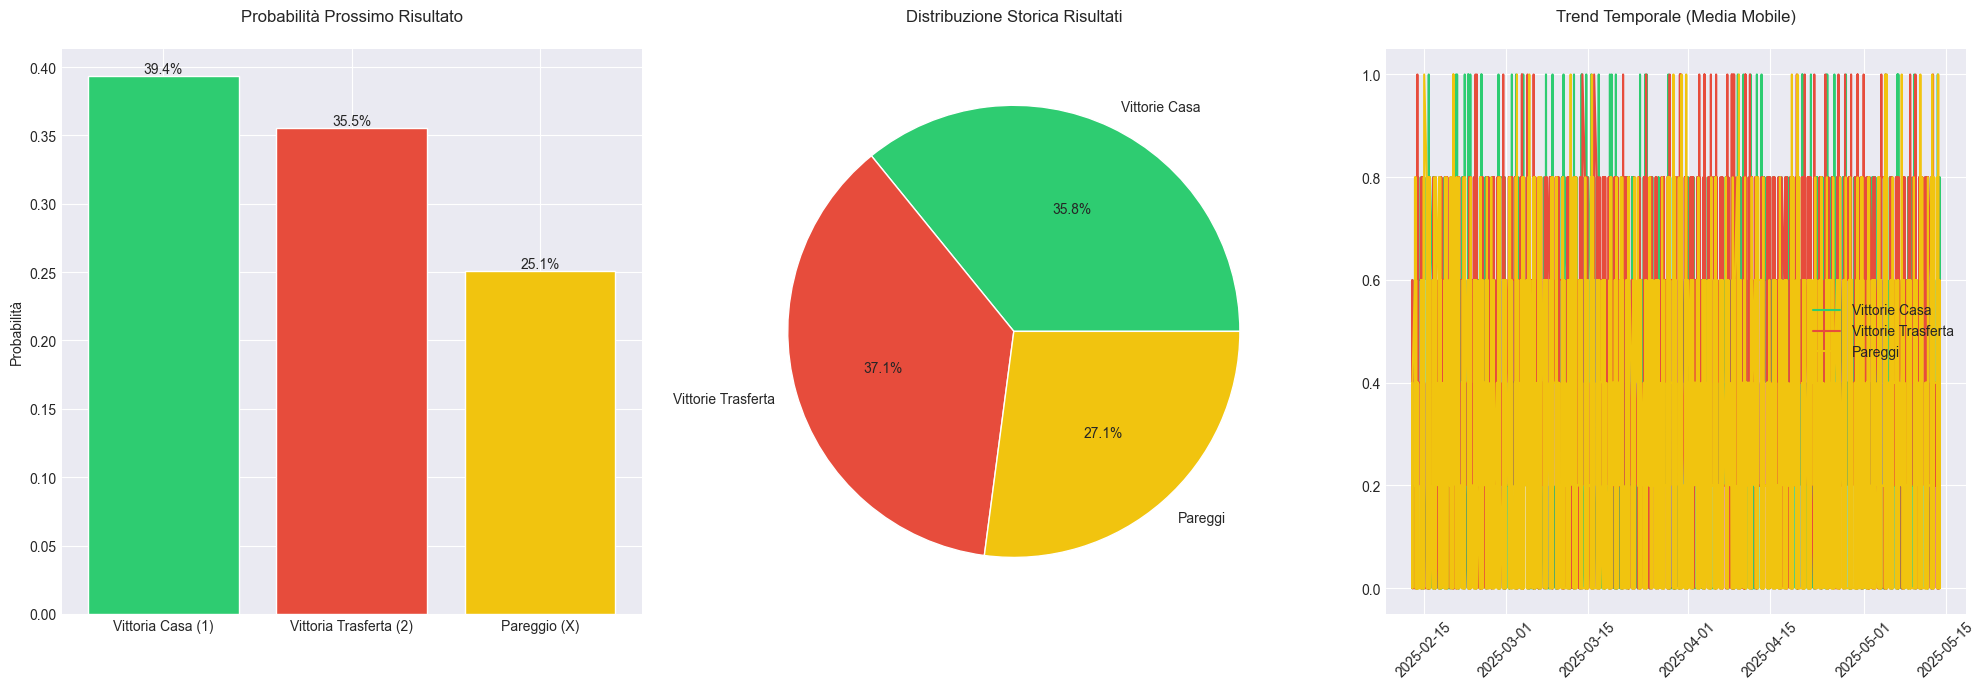

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


class SoccerAnalyzer:
    def __init__(self, filename):
        """
        Inizializza l'analizzatore con il file dei dati
        Args:
            filename (str): Path del file CSV
        """
        try:
            # Leggi il file CSV
            self.data = pd.read_csv(filename)
            # Converti la colonna datetime in formato datetime
            self.data['datetime'] = pd.to_datetime(self.data['datetime'])
            # Ordina per data/ora
            self.data = self.data.sort_values('datetime')

            # Validazione dati
            required_columns = ['datetime', 'result', 'home_team', 'away_team', 'score']
            if not all(col in self.data.columns for col in required_columns):
                raise ValueError("CSV mancante di colonne richieste")

            print(f"Dati caricati: {len(self.data)} partite")
            print(f"Periodo: da {self.data['datetime'].min()} a {self.data['datetime'].max()}")

        except FileNotFoundError:
            raise FileNotFoundError(f"File {filename} non trovato")
        except Exception as e:
            raise Exception(f"Errore nel caricamento dei dati: {str(e)}")

    def calculate_markov_probabilities(self):
        """Calcola le probabilità usando le catene di Markov con smoothing"""
        results = self.data['result'].astype(str).values
        transitions = {'1': [], '2': [], 'X': []}

        # Calcolo transizioni
        for i in range(len(results) - 1):
            current = results[i]
            next_result = results[i + 1]
            transitions[current].append(next_result)

        # Applica smoothing di Laplace
        smoothing_factor = 0.5
        probabilities = {}
        for result in transitions:
            if transitions[result]:
                total = len(transitions[result]) + (smoothing_factor * 3)  # 3 possibili stati
                prob_dist = {
                    '1': (transitions[result].count('1') + smoothing_factor) / total,
                    '2': (transitions[result].count('2') + smoothing_factor) / total,
                    'X': (transitions[result].count('X') + smoothing_factor) / total
                }
                probabilities[result] = prob_dist

        return probabilities

    def calculate_bayes_probabilities(self):
        """Calcola le probabilità usando Bayes con prior informativo"""
        total_matches = len(self.data)
        results_count = self.data['result'].astype(str).value_counts()

        # Prior informativo basato su statistiche storiche del calcio
        prior = {'1': 0.45, '2': 0.30, 'X': 0.25}  # Aggiornato con statistiche reali

        # Calcolo likelihood con smoothing
        smoothing_factor = 0.5
        likelihood = {
            '1': (results_count.get('1', 0) + smoothing_factor) / (total_matches + smoothing_factor * 3),
            '2': (results_count.get('2', 0) + smoothing_factor) / (total_matches + smoothing_factor * 3),
            'X': (results_count.get('X', 0) + smoothing_factor) / (total_matches + smoothing_factor * 3)
        }

        evidence = sum(prior[k] * likelihood[k] for k in prior)
        posterior = {k: (prior[k] * likelihood[k]) / evidence for k in prior}

        return posterior

    def predict_next_match(self):
        """Combina le predizioni con pesi dinamici"""
        markov = self.calculate_markov_probabilities()
        bayes = self.calculate_bayes_probabilities()

        last_result = str(self.data.iloc[-1]['result'])
        last_match = self.data.iloc[-1]

        # Pesi dinamici basati sulla "forza" dell'ultimo risultato
        markov_weight = 0.7 if last_result in markov else 0.5
        bayes_weight = 1 - markov_weight

        if last_result in markov:
            markov_pred = markov[last_result]
        else:
            markov_pred = {'1': 1/3, '2': 1/3, 'X': 1/3}

        final_pred = {
            k: (markov_weight * markov_pred[k] + bayes_weight * bayes[k])
            for k in ['1', '2', 'X']
        }

        print(f"\nUltima partita: {last_match['home_team']} vs {last_match['away_team']} ({last_match['score']})")
        return final_pred

    def plot_predictions(self):
        """Crea una visualizzazione migliorata delle predizioni"""
        predictions = self.predict_next_match()

        # Set the style using a valid matplotlib style
        plt.style.use('seaborn-v0_8-darkgrid')  # Using a valid style name

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

        # 1. Grafico a barre delle probabilità
        colors = ['#2ecc71', '#e74c3c', '#f1c40f']
        labels = ['Vittoria Casa (1)', 'Vittoria Trasferta (2)', 'Pareggio (X)']
        values = [predictions['1'], predictions['2'], predictions['X']]

        bars = ax1.bar(labels, values, color=colors)
        ax1.set_title('Probabilità Prossimo Risultato', pad=20, size=12)
        ax1.set_ylabel('Probabilità')

        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}', ha='center', va='bottom')

        # 2. Grafico trend storico
        results_history = self.data['result'].astype(str).value_counts(normalize=True)
        ax2.pie([results_history.get('1', 0),
                 results_history.get('2', 0),
                 results_history.get('X', 0)],
                labels=['Vittorie Casa', 'Vittorie Trasferta', 'Pareggi'],
                colors=colors,
                autopct='%1.1f%%')
        ax2.set_title('Distribuzione Storica Risultati', pad=20, size=12)

        # 3. Trend temporale
        dates = self.data['datetime'].values
        results = pd.get_dummies(self.data['result'].astype(str))

        # Add error handling for rolling mean calculation
        window_size = min(5, len(dates))  # Adjust window size if data is too short

        if len(dates) > 0:
            ax3.plot(dates, results['1'].rolling(window_size).mean(),
                    label='Vittorie Casa', color='#2ecc71')
            ax3.plot(dates, results['2'].rolling(window_size).mean(),
                    label='Vittorie Trasferta', color='#e74c3c')
            ax3.plot(dates, results['X'].rolling(window_size).mean(),
                    label='Pareggi', color='#f1c40f')

        ax3.set_title('Trend Temporale (Media Mobile)', pad=20, size=12)
        ax3.legend()
        ax3.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        return plt


def main():
    try:
        analyzer = SoccerAnalyzer('virtual_matches_data.csv')
        predictions = analyzer.predict_next_match()

        print("\nPredizioni per il prossimo match:")
        print(f"Vittoria Casa (1): {predictions['1']:.1%}")
        print(f"Pareggio (X): {predictions['X']:.1%}")
        print(f"Vittoria Trasferta (2): {predictions['2']:.1%}")

        plt = analyzer.plot_predictions()
        plt.show()

    except Exception as e:
        print(f"Errore durante l'esecuzione: {str(e)}")


if __name__ == "__main__":
    main()

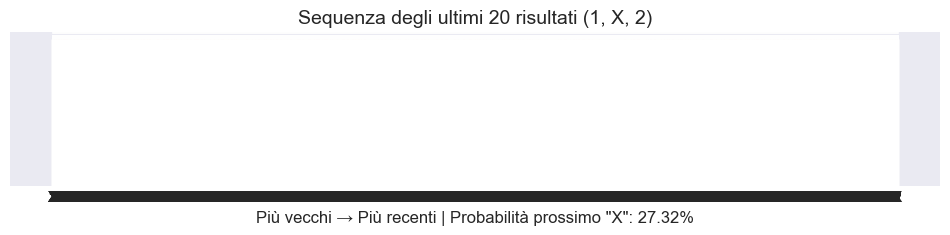

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Caricare il file CSV
file_path = 'virtual_matches_data.csv'  # Cambia con il percorso corretto del file
data = pd.read_csv(file_path)

# Convertire la colonna della data in formato datetime per il filtraggio e ordinamento
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.sort_values(by='datetime')  # Ordinare per data

# Estrarre gli ultimi 20 eventi
last_20_events = data
sequence = last_20_events['result'].tolist()

# Calcolare le probabilità di transizione per il modello di Markov
transitions = {'1': {'1': 0, 'X': 0, '2': 0},
               'X': {'1': 0, 'X': 0, '2': 0},
               '2': {'1': 0, 'X': 0, '2': 0}}

# Popolare la matrice delle transizioni
for i in range(1, len(sequence)):
    prev = sequence[i - 1]
    curr = sequence[i]
    transitions[prev][curr] += 1

# Normalizzare per ottenere le probabilità
for state, counts in transitions.items():
    total = sum(counts.values())
    if total > 0:
        for next_state in counts:
            transitions[state][next_state] /= total

# Probabilità che il prossimo evento sia "X" dato l'ultimo evento
last_event = sequence[-1]
prob_next_X = transitions[last_event]['X']

# Creare il grafico sequenziale
plt.figure(figsize=(12, 2))
plt.bar(
    range(len(sequence)),
    [1]*len(sequence),
    color=[
        '#4CAF50' if x == '1' else '#FFC107' if x == 'X' else '#F44336'
        for x in sequence
    ],
    tick_label=sequence,
    width=1
)
plt.title('Sequenza degli ultimi 20 risultati (1, X, 2)', fontsize=14)
plt.xlabel(f'Più vecchi → Più recenti | Probabilità prossimo "X": {prob_next_X:.2%}', fontsize=12)
plt.yticks([])  # Rimuovere l'asse Y per chiarezza
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


diversi test

In [9]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

# Funzione per creare features storiche per ogni squadra
def create_team_features(df, window=5):
    df = df.sort_values('datetime')
    teams = pd.concat([df['home_team'], df['away_team']]).unique()
    team_stats = {}

    for team in teams:
        # Statistiche come home team e away team
        home_games = df[df['home_team'] == team].copy()
        away_games = df[df['away_team'] == team].copy()

        for games, prefix in zip([home_games, away_games], ['home', 'away']):
            games['goals_scored'] = games[f'{prefix}_goals']
            games['goals_conceded'] = games[f'{"home" if prefix == "away" else "away"}_goals']
            games['is_draw'] = (games['result'] == 'X').astype(int)

            if team not in team_stats:
                team_stats[team] = pd.DataFrame()

            team_stats[team] = pd.concat([team_stats[team], games[['datetime', 'goals_scored', 'goals_conceded', 'is_draw']]])

    for team in team_stats:
        team_stats[team] = team_stats[team].sort_values('datetime')
        team_stats[team]['avg_goals_scored'] = team_stats[team]['goals_scored'].rolling(window, min_periods=1).mean()
        team_stats[team]['avg_goals_conceded'] = team_stats[team]['goals_conceded'].rolling(window, min_periods=1).mean()
        team_stats[team]['draw_ratio'] = team_stats[team]['is_draw'].rolling(window, min_periods=1).mean()

    return team_stats

# Funzione per preparare il dataset
def prepare_dataset(df, team_stats):
    features = []

    for idx, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        match_time = row['datetime']

        def get_stats(team, team_stats, match_time):
            team_stats_slice = team_stats[team][team_stats[team]['datetime'] < match_time]
            if not team_stats_slice.empty:
                return {
                    'avg_goals_scored': team_stats_slice['avg_goals_scored'].iloc[-1],
                    'avg_goals_conceded': team_stats_slice['avg_goals_conceded'].iloc[-1],
                    'draw_ratio': team_stats_slice['draw_ratio'].iloc[-1],
                }
            else:
                return {'avg_goals_scored': 0, 'avg_goals_conceded': 0, 'draw_ratio': 0}

        home_stats = get_stats(home_team, team_stats, match_time)
        away_stats = get_stats(away_team, team_stats, match_time)

        match_features = {
            'match_id': idx,
            'home_team': home_team,
            'away_team': away_team,
            'odds_1': row['odds_1'],
            'odds_over_under_25': row['odds_over_under_25'],
            'odds_goal_no_goal': row['odds_goal_no_goal'],
            **home_stats,
            **away_stats
        }

        features.append(match_features)

    return pd.DataFrame(features)

# Carica e prepara i dati
df = pd.read_csv('virtual_matches_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

# Crea target binario (1 per pareggio, 0 per non pareggio)
df['is_draw'] = (df['result'] == 'X').astype(int)

# Crea features storiche
team_stats = create_team_features(df)

# Prepara il dataset con le features
features_df = prepare_dataset(df, team_stats)
features_df = features_df.set_index('match_id')

# Prepara X e y
X = features_df.drop(['home_team', 'away_team'], axis=1)
y = df['is_draw']

# Dividi i dati in train, validation e test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

# Definisci le categorical features (vuoto in questo contesto)
cat_features = []

# Crea i Pool di dati per CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

# Inizializza e addestra il modello
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    task_type="GPU",
    eval_metric='AUC',
    early_stopping_rounds=50,
    class_weights={0: 1, 1: 2},
    random_state=42
)

model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=100
)

# Valuta il modello
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Funzione per fare previsioni su nuove partite
def predict_new_matches(new_matches_df, model, team_stats):
    new_features_df = prepare_dataset(new_matches_df, team_stats)
    X_new = new_features_df.drop(['match_id', 'home_team', 'away_team'], axis=1)
    predictions = model.predict_proba(X_new)
    results_df = new_matches_df.copy()
    results_df['draw_probability'] = predictions[:, 1]
    results_df['predicted_draw'] = model.predict(X_new)
    return results_df

# Carica e predici le nuove partite
new_matches = pd.read_csv('previsione.csv')
new_matches['datetime'] = pd.to_datetime(new_matches['datetime'])
predictions = predict_new_matches(new_matches, model, team_stats)

print("\nPrevisioni per le prossime partite:")
for _, match in predictions.iterrows():
    print(f"\n{match['home_team']} vs {match['away_team']}")
    print(f"Probabilità di pareggio: {match['draw_probability']:.2%}")
    print(f"Previsione: {'Pareggio' if match['predicted_draw'] == 1 else 'Non Pareggio'}")

KeyboardInterrupt: 